In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset

In [4]:
data = pd.read_csv("/content/sample_data/Combined Data.csv")

# Drop Unnamed column
data = data.drop(columns=['Unnamed: 0'])
data.dropna(inplace=True)

data

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [5]:
data = data.sample(n=40000,).reset_index(drop=True)
data

,statement,status
0,Hey guys. I have basically been in a super str...,Depression
1,"you don't need to have cable, but you do need ...",Normal
2,I am not really sure where else to post this.w...,Suicidal
3,"hi, I'm new again.. yesterday it was really ha...",Normal
4,Her name was Chinook. I wasn't there. Edit--th...,Normal
...,...,...
39995,Not feeling myself Lately I haven’t been feeli...,Anxiety
39996,up and throat still hurt,Normal
39997,i want to end it so badly now everything in my...,Depression
39998,"I phoned my actual therapist, but mostly I sat...",Normal


In [8]:
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    # Convert to lowercase
    statement = statement.lower()

    # Remove special characters
    statement = re.sub(r'[^\w\s]', '', statement)

    # Remove numbers
    statement = re.sub(r'\d+', '', statement)

    # Tokenize the statement (split into words)
    words = statement.split()

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Rejoin words into a cleaned statement
    cleaned_statement = ' '.join(words)

    return cleaned_statement

# Apply the cleaning function to the 'statement' column
data['statement'] = data['statement'].apply(clean_statement)

data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,statement,status
0,hey guys basically super stressful bad situati...,Depression
1,dont need cable need good antenna,Normal
2,really sure else post thiswhen whole covid bre...,Suicidal
3,hi im new yesterday really hard open twitter l...,Normal
4,name chinook wasnt editthe vet suspected bad h...,Normal
...,...,...
39995,feeling lately havent feeling feel weird idk c...,Anxiety
39996,throat still hurt,Normal
39997,want end badly everything life pain mind teari...,Depression
39998,phoned actual therapist mostly sat alone chain...,Normal


In [9]:
data['status'].value_counts()

,count
status,
Normal,12306
Depression,11724
Suicidal,8103
Anxiety,2933
Bipolar,2102
Stress,2006
Personality disorder,826


In [10]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Defining features (X) and target (y)
X = data.drop(columns=['status'])
y = data['status']

# Performing oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combining the oversampled features and target back into a df
data = pd.concat([X_resampled, y_resampled], axis=1)

# Check the new class distribution
print(data['status'].value_counts())

status
Depression              12306
Normal                  12306
Suicidal                12306
Anxiety                 12306
Personality disorder    12306
Stress                  12306
Bipolar                 12306
Name: count, dtype: int64


In [11]:
# Label encoding for 'status' column
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])

In [12]:
train_texts, test_texts, train_labels, test_labels = train_test_split(data['statement'], data['label'], test_size=0.2)

In [13]:
max([len(text) for text in data['statement']])

25199

In [14]:
# Tokenization using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels.tolist()})

In [16]:
BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [17]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Set training arguments

training_args = TrainingArguments(
    output_dir="./results",          # Output directory for results
    evaluation_strategy="epoch",     # Evaluate once per epoch
    save_strategy="epoch",           # Save model at the end of each epoch to match evaluation strategy
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=5,              # Increase number of epochs
    weight_decay=0.01,               # Strength of weight decay
    logging_dir="./logs",            # Directory for logging
    logging_steps=10,                # Log every 10 steps
    lr_scheduler_type="linear",      # Use linear learning rate scheduler with warmup
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Monitor eval loss to determine the best model
    save_total_limit=3,              # Limit the number of checkpoints to save
    gradient_accumulation_steps=2    # Simulate larger batch size if GPU memory is limited
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tuning the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anushkakute48 (anushkakute48-sunbeam-infotech) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.305600,0.325819
2,0.171900,0.240930
3,0.153500,0.211443
4,0.049100,0.236578


Epoch,Training Loss,Validation Loss
1,0.305600,0.325819
2,0.171900,0.240930
3,0.153500,0.211443
4,0.049100,0.236578
5,0.106700,0.278543


TrainOutput(global_step=10770, training_loss=0.2421413183087758, metrics={'train_runtime': 12616.3816, 'train_samples_per_second': 27.311, 'train_steps_per_second': 0.854, 'total_flos': 3.541520731905e+16, 'train_loss': 0.2421413183087758, 'epoch': 5.0})

                      precision    recall  f1-score   support

             Anxiety       0.98      0.99      0.99      2453
             Bipolar       0.99      1.00      0.99      2432
          Depression       0.86      0.71      0.78      2566
              Normal       0.95      0.95      0.95      2422
Personality disorder       0.99      1.00      1.00      2506
              Stress       0.96      0.99      0.98      2464
            Suicidal       0.77      0.87      0.82      2386

            accuracy                           0.93     17229
           macro avg       0.93      0.93      0.93     17229
        weighted avg       0.93      0.93      0.93     17229



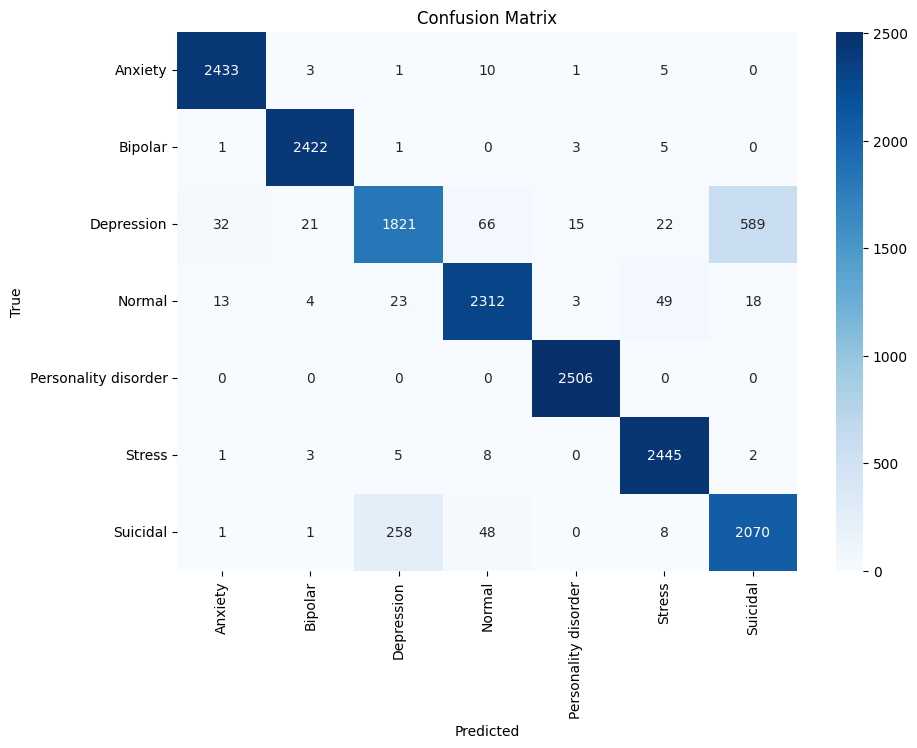

In [18]:
# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
accuracy

0.9291891578153114

In [20]:
trainer.save_model("saved_mental_status_bert")  # Save the model
tokenizer.save_pretrained("saved_mental_status_bert") # Save the tokenizer
import pickle

# Save the label encoder
with open('label_encoder.pkl', 'wb') as file:
     pickle.dump(label_encoder, file)

In [21]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer from the saved paths
model = AutoModelForSequenceClassification.from_pretrained("saved_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("saved_mental_status_bert")

label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

In [22]:
# Detection System (Example)
def detect_anxiety(text):
    cleaned_text = clean_statement(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

# Test detection system with a mixture of normal, anxiety, bipolar, depression, suicide, etc.
sample_texts = [
    "I feel perfectly fine today, nothing to worry about.",
    "I'm so sad, I just can't seem to get out of bed anymore.",
    "I'm constantly thinking about how much better everyone else is doing than me.",
    "I don't think I can keep going, everything feels so hopeless.",
    "I had a really good day, spent some time with my friends.",
    "I'm overwhelmed by the idea that I might lose everything.",
    "I feel like nothing matters anymore, I just want to give up.",
    "I'm okay today, but sometimes I get really anxious for no reason."
]

# Assuming the detect_anxiety function is already defined and takes a sentence as input
for text in sample_texts:
    predicted_class = detect_anxiety(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")

Sentence: I feel perfectly fine today, nothing to worry about.
Predicted class: Anxiety

Sentence: I'm so sad, I just can't seem to get out of bed anymore.
Predicted class: Normal

Sentence: I'm constantly thinking about how much better everyone else is doing than me.
Predicted class: Normal

Sentence: I don't think I can keep going, everything feels so hopeless.
Predicted class: Depression

Sentence: I had a really good day, spent some time with my friends.
Predicted class: Normal

Sentence: I'm overwhelmed by the idea that I might lose everything.
Predicted class: Normal

Sentence: I feel like nothing matters anymore, I just want to give up.
Predicted class: Suicidal

Sentence: I'm okay today, but sometimes I get really anxious for no reason.
Predicted class: Anxiety



In [23]:
import shutil
from google.colab import files

# Step 1: Save the trained model and tokenizer
model_save_path = "saved_mental_status_bert"
tokenizer_save_path = "saved_mental_status_bert"
# Save the model and tokenizer
trainer.save_model(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

# Step 2: Create a zip file containing the saved model and tokenizer using shutil
zip_file_path = "saved_mental_status_bert"
# Create a zip archive of the directories
shutil.make_archive(zip_file_path, 'zip', root_dir='saved_mental_status_bert', base_dir='')

# Step 3: Provide a download link to the zip file
files.download(f"{zip_file_path}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download stopwords
nltk.download('stopwords')

try:
    # Replace 'error_bad_lines' with 'on_bad_lines' and set it to 'skip' to ignore bad lines
    df = pd.read_csv("/content/sample_data/Combined Data.csv", on_bad_lines='skip', quoting=3)
except pd.errors.ParserError as e:
    # If the error persists, print detailed information for diagnosis
    print(f"An error occurred while reading the CSV: {e}")

# Text Cleaning Function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

# Apply text cleaning
df["clean_text"] = df["statement"].apply(clean_text)

# Save to CSV for Tableau
df.to_csv("cleaned_text_data.csv", index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
words = " ".join(df["clean_text"]).split()
word_freq = Counter(words).most_common(20)  # Top 20 words
word_df = pd.DataFrame(word_freq, columns=["Word", "Count"])
word_df.to_csv("word_frequency.csv", index=False)

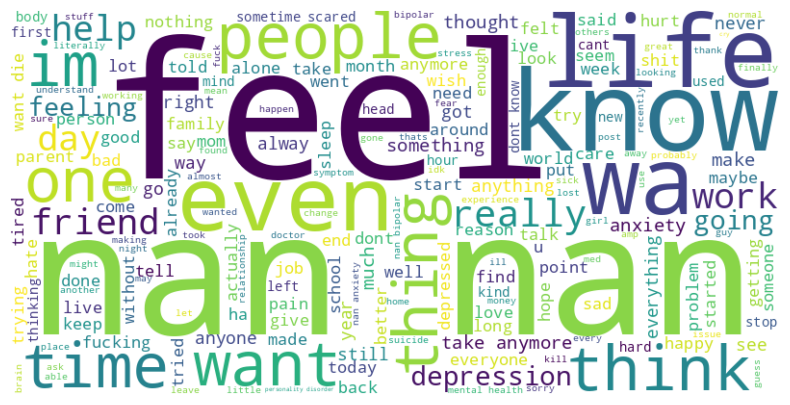

In [26]:
wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [27]:
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df["Sentiment"] = df["clean_text"].apply(get_sentiment)
df.to_csv("sentiment_analysis.csv", index=False)

In [28]:
df["Text_Length"] = df["clean_text"].apply(lambda x: len(x.split()))
df.to_csv("text_length_distribution.csv", index=False)

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Load Data
df = pd.read_csv("cleaned_text_data.csv")

# Handle NaN values in the 'clean_text' column
df['clean_text'] = df['clean_text'].fillna('')  # Replace NaN with empty string
# Alternatively, drop rows with NaN values:
# df.dropna(subset=['clean_text'], inplace=True)

# Generate Bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df["clean_text"])  # .fillna('') is removed
bigram_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().reset_index()
bigram_counts.columns = ["Bigram", "Count"]
bigram_counts = bigram_counts.sort_values(by="Count", ascending=False).head(20)
bigram_counts.to_csv("bigram_analysis.csv", index=False)

# Generate Trigrams
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
X = vectorizer.fit_transform(df["clean_text"])
trigram_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().reset_index()
trigram_counts.columns = ["Trigram", "Count"]
trigram_counts = trigram_counts.sort_values(by="Count", ascending=False).head(20)
trigram_counts.to_csv("trigram_analysis.csv", index=False)

In [30]:
df["status"].value_counts().to_csv("class_distribution.csv")

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

y_true = test_labels
y_pred = predicted_labels

y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)

unique_labels = np.unique(np.concatenate((y_true, y_pred)))

cm = confusion_matrix(y_true, y_pred)

cm_df = pd.DataFrame(cm,
                     index=[label_encoder.classes_[i] for i in unique_labels],
                     columns=[label_encoder.classes_[i] for i in unique_labels])

cm_df.to_csv("confusion_matrix.csv")